### Importing all libraries

In [1]:
#Importing audio file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np

#PyTorch
import torchaudio
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch import nn

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import ConfusionMatrix

# Misc.
import warnings
import librosa
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook
from IPython.display import Audio

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


### Recursively get all audio files

In [2]:
def audio_fetch(src,audio_paths):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(".wav" in l[i] or ".mp3" in l[i] or ".aac" in l[i]):
                audio_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    audio_fetch(str(src+"/"+l[i]+"/"),audio_paths)
                except:
                    continue
                            
# For getting all possible classes along with their label encoding as a dictionary
def class_fetch(df: pd.DataFrame())->(list,dict):
    s=sorted(df[1].unique())
    
    toDel=[i for i in dict(df[1].value_counts(sort=True)).keys() if dict(df[1].value_counts(sort=True))[i]<3]
    for i in toDel:
        s.remove(i)
    d={}
    
    toDel_ids=[]
    for i in toDel:
        toDel_ids.extend(list(df[df[1]==i][0].values))
    
    
    count=0
    for i in s:
        d[i]=count
        count+=1
    return list(s),d, toDel_ids

### Data Augmentation

In [3]:
def add_noise(data,alpha=0.015):
    noise_value = alpha * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data

def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def pitch_process(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


def extract_process(data, sample_rate):
    output_result = np.array([])

    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))

    
    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))
    

    return output_result


def extract_features(file_name):
    
    """
    This function takes in the path for an audio file as a string, loads it,
    and extracts several audio features including mean values of MFCC, Zero Crossing Rate,
    Chromagram, Root Mean Square Energy, and Mel Spectrogram from the original and its augmented versions.
    """
    
    try:
        # Load the original audio file
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)

        # Extract features from the original audio data
        extracted_features = extract_process(audio, sample_rate)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result

### Dataset Class

In [4]:
class audio_dataset(Dataset):
    def __init__(self,
                 info: str,
                 audio_path=None,
                 audio_file_path=None,
                 audio_files=None,
                 audio_files_labels=None,
                 header=None,
                 transform=False) -> None:
        
        self.paths=[]
        self.audio_files=[]
        self.y=[]
        
        if (audio_path==None and audio_file_path==None and audio_files==None):
            raise Exception("audio_path, audio_file_path and audio_files cannot be None at the same time")

        if(audio_file_path==None and audio_files==None):
            audio_fetch(audio_path,self.paths)
        elif(audio_file_path!=None and audio_files==None):
            self.paths=audio_file_path
        else:
            self.audio_files=audio_files
            self.y=audio_files_labels
        
        self.patient=dict()
        self.paths.sort() 
        
        # We are going to remove all classes than 2 patient data

        for i in self.paths:
            index=int(i.split("/")[-1].split("_")[0])
            self.patient[index]=[]
        
        for i in range(len(self.paths)):
            self.patient[int(self.paths[i].split("/")[-1].split("_")[0])].append(self.paths[i])
        
        self.info_df=pd.read_csv(info,header=header)
        self.classes, self.class_to_idx, self.ids_to_remove = class_fetch(self.info_df)

        # After getting the patient ids to remove all the data from patient list is removed
        for i in self.ids_to_remove:
            if i in self.patient.keys():
                self.patient.pop(i)

        #Denotes sequence of audio files for a particular patient
        self.sequence=list(self.patient.values())

        # Audio path is updated after removing classing with small number of patients
        self.paths=[]
        for i in self.sequence:
            if(i!=[]):
                for j in i:
                    self.paths.append(j)

        self.scaler=StandardScaler()
        self.transform=transform
    
    def get_class(self,file: str):
        return self.info_df[self.info_df[0]==int(file.split("/")[-1].split("_")[0])][1].values[0]

    def get_all_class_idx(self) -> list:
        l=[]
        if(len(self.audio_files)==0):
            for i in range(len(self.paths)):
                l.append(self.class_to_idx[self.info_df[self.info_df[0]==int(self.paths[i].split("/")[-1].split("_")[0])][1].values[0]])
            return l
        else:
            raise Exception("Cannot get all class idx when directly using audio files")

    
    def apply_transform(self,x,sr):
        n=torch.randint(low=0,high=2,size=(1,))
        x=add_noise(x,0.015*n.item())
        x=stretch_process(x,0.8*n.item())
        x=pitch_process(x,sr,0.7*n.item())
        return x
    
    def __len__(self) -> int:
        if(len(self.audio_files)==0):
            return len(self.paths)
        else:
            return len(self.y)


    def __getitem__(self, index: int) -> torch.Tensor():
        if(len(self.audio_files)==0):
            self.val=self.paths[index]
            self.class_val=self.class_to_idx[self.get_class(self.val)]
    
            self.signal, self.sr = librosa.load(self.val)
            if(self.transform!=False):
                self.signal=self.apply_transform(self.signal,self.sr)
            self.signal = torch.unsqueeze(torch.from_numpy(np.squeeze(self.scaler.fit_transform(np.reshape(extract_process(self.signal, self.sr),newshape=(-1,1))))),dim=0).type(torch.float32)
            
            return self.signal,self.class_val
            
        else:
            return torch.unsqueeze(torch.tensor(self.audio_files[index]),dim=0).type(torch.float32),self.class_to_idx[self.y[index]]

##### Testing audio dataset

In [5]:
ds=audio_dataset(audio_path="../Sound_Classification/archive/Respiratory_Sound_Database/",info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")
ds.class_to_idx

{'Bronchiectasis': 0,
 'Bronchiolitis': 1,
 'COPD': 2,
 'Healthy': 3,
 'Pneumonia': 4,
 'URTI': 5}

In [6]:
print(len(ds.sequence))
print(ds.get_class(ds.paths[3]))

123
COPD


### Dataloader

In [7]:
BATCH_SIZE=32
SPLIT=0.2
ds=[]
audio_fetch("../Sound_Classification/archive/respiratory_sound_database/",ds)

# Perform train test split
train_ds,temp_ds=train_test_split(ds,test_size=SPLIT,shuffle=True)
test_ds,val_ds=train_test_split(temp_ds,test_size=0.0001,shuffle=True)

print(f"Before trimming:")
print(f"No. of audio files in train_ds: {len(train_ds)}\nNo. of audio files in test_ds: {len(test_ds)}\nNo. of audio files in val_ds: {len(val_ds)}")


train_ds=audio_dataset(audio_file_path=train_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",transform=True)
test_ds=audio_dataset(audio_file_path=test_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",transform=True)
val_ds=audio_dataset(audio_file_path=val_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")

print(f"\nAfter trimming:")
print(f"No. of audio files in train_ds: {train_ds.__len__()}\nNo. of audio files in test_ds: {test_ds.__len__()}\nNo. of audio files in val_ds: {val_ds.__len__()}")


key=int(input("\nDo you want to augment data (0 or 1): "))

if(key):
    features = []
    labels = []
    info_df=pd.read_csv("../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None)
    
    # Iterate through each sound file and extract the features
    for file_name in train_ds.paths:
        data = extract_features(file_name)
        label=info_df[info_df[0]==int(file_name.split("/")[-1].split("_")[0])][1].values[0]
        labels.append(label)
        features.append(data)
            
    print('\nFinished feature extraction from ', len(features), ' files')
    features = np.array(features)
    labels=np.array(labels)
    
    augmented_features = np.reshape(features, (-1, 182))
    augmented_labels = np.repeat(labels, 3)
    
    train_ds.audio_files=augmented_features
    train_ds.y=augmented_labels

    print(f"\nAfter augmentaion:")
    print(f"No. of audio files in train_ds: {train_ds.__len__()}\nNo. of audio files in test_ds: {test_ds.__len__()}\nNo. of audio files in val_ds: {val_ds.__len__()}")

try:
    def get_class_weight_sampler(ds: audio_dataset) -> torch.Tensor():
        y=[]
        try:
            for i in range(ds.__len__()):
                y.append(ds.get_class(ds.paths[i]))
            class_weights = dict(1/pd.Series(y).value_counts())
        except Exception as e:
            class_weights = dict(1/pd.Series(ds.y).value_counts())
    
        wt=[]
        for i in ds.classes:
            wt.append(class_weights[i])
        weight=[wt[i] for i in ds.get_all_class_idx()]
        
        return weight

    weights=get_class_weight_sampler(train_ds)
    sampler_train=torch.utils.data.WeightedRandomSampler(weights=weights, num_samples=train_ds.__len__(), replacement=True)

    weights=get_class_weight_sampler(test_ds)
    sampler_test=torch.utils.data.WeightedRandomSampler(weights=weights, num_samples=test_ds.__len__(), replacement=True)
  
    train_loader=torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,sampler=sampler_train)
    test_loader=torch.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE,sampler=sampler_test)
    val_loader=torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)

    print(f"\nData loaded with oversampling")

except Exception as e:
    print(f"\n{e}\n")
    train_loader=torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
    test_loader=torch.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)
    val_loader=torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)
    print(f"\nData loaded without oversampling")

Before trimming:
No. of audio files in train_ds: 736
No. of audio files in test_ds: 183
No. of audio files in val_ds: 1

After trimming:
No. of audio files in train_ds: 734
No. of audio files in test_ds: 182
No. of audio files in val_ds: 1



Do you want to augment data (0 or 1):  0



Data loaded with oversampling


### Class imbalance check

In [8]:
def show_imbalance(dl: torch.utils.data.DataLoader, batches: int, train_ds: torch.utils.data.Dataset):
    for i in range(batches):
        data, label=next(iter(dl))
        data_qty={i:0 for i in range(len(train_ds.classes))}
        for i in label:
            data_qty[i.item()]+=1
        print(data_qty)

In [9]:
show_imbalance(train_loader,5,train_ds)

{0: 4, 1: 3, 2: 4, 3: 6, 4: 6, 5: 9}
{0: 4, 1: 5, 2: 7, 3: 4, 4: 5, 5: 7}
{0: 5, 1: 5, 2: 4, 3: 9, 4: 5, 5: 4}
{0: 2, 1: 4, 2: 7, 3: 7, 4: 8, 5: 4}
{0: 4, 1: 7, 2: 4, 3: 6, 4: 4, 5: 7}


##### Checking dataloader

In [10]:
im=next(iter(train_loader))[0]
im.shape

torch.Size([32, 1, 182])

In [11]:
im[0].dtype

torch.float32

In [12]:
assert ((train_ds.classes==test_ds.classes and test_ds.classes==val_ds.classes))

### Setting up Tensorboard and performance metrics

In [13]:
log_dir = "../"+"performance"
writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

f1_fn=MulticlassF1Score(num_classes=len(train_ds.classes)).to(device)
cf_matrix=ConfusionMatrix(num_classes=len(train_ds.classes),task="multiclass")

### Model 1 (Simple Conv1D Network)

In [14]:
class auditory_transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_embedding=nn.Sequential(nn.Conv1d(in_channels=1,out_channels=256,stride=1,kernel_size=5),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=256,out_channels=256,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=1,padding=1),
                                           nn.Conv1d(in_channels=256,out_channels=128,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=128,out_channels=64,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=64,out_channels=32,kernel_size=5),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Dropout(p=0.2),
                                           nn.Flatten(),
                                           nn.ReLU(),
                                           nn.Linear(in_features=192,out_features=32,bias=True),
                                           nn.ReLU(),
                                           nn.Dropout(p=0.3),
                                           nn.Linear(in_features=32,out_features=len(train_ds.classes),bias=True))

    def forward(self,x):
        return self.input_embedding(x)

#### Model 1 testing and training

In [15]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 182])

In [16]:
model=auditory_transformer().to(device)
with torch.inference_mode():
    print(model((next(iter(train_loader))[0]).to(device)).shape)

torch.Size([32, 6])


##### Optimizer and loss function

In [17]:
optimizer=torch.optim.Adam(params=model.parameters())
loss_fn=nn.CrossEntropyLoss()

#print(f"Taking class weights:\n{get_class_weight(train_ds)}\n{train_ds.classes}")

##### Training Function

In [18]:
def train_model(model,epochs):
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        test_preds=torch.tensor([])
        train_actual=torch.tensor([])
        test_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and test data
        temp_train_accuracy=[]
        temp_test_accuracy=[]
        temp_train_loss=[]
        temp_test_loss=[]
        temp_train_f1=[]
        temp_test_f1=[]
    
        net_train_accuracy=0
        net_test_accuracy=0
        net_train_loss=0
        net_test_loss=0
        net_train_f1=0
        net_test_f1=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(logits.squeeze(),y)
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    train_preds=torch.hstack((train_preds,preds.to("cpu")))
                    train_actual=torch.hstack((train_actual,y.to("cpu")))
                    accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                    f1_train=f1_fn(preds,y)
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                    temp_train_f1.append(f1_train.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        #Tensorboard & Metrics for the dataset
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
        net_train_f1=sum(temp_train_f1)/len(temp_train_f1)
        writer.add_scalar("Train Accuracy",net_train_accuracy,i)
        writer.add_scalar("Train Loss",net_train_loss,i)
        writer.add_scalar("Train F1 Score",net_train_f1,i)
    
        #Evaluation
        print("Testing:")
        model.eval()
    
        with tqdm_notebook(total=len(test_loader)) as pbar2:
            for x,y in test_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(logits.squeeze().type(torch.float32),y)
    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    test_preds=torch.hstack((test_preds,preds.to("cpu")))
                    test_actual=torch.hstack((test_actual,y.to("cpu")))
                    accuracy_test=accuracy_fn(logits,y)
                    f1_test=f1_fn(preds,y)
                    temp_test_accuracy.append(accuracy_test)
                    temp_test_loss.append(loss.item())
                    temp_test_f1.append(f1_test.item())
    
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        #Tensorboard & Metrics for the dataset
        net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
        net_test_loss=sum(temp_test_loss)/len(temp_test_loss)
        net_test_f1=sum(temp_test_f1)/len(temp_test_f1)
        writer.add_scalar("Test Accuracy",net_test_accuracy,i)
        writer.add_scalar("Test Loss",net_test_loss,i)
        writer.add_scalar("Test F1 Score",net_test_f1,i)

        '''
        #Saving the model
        try:
            os.makedirs(f"./{model_name}_feature_extractor/")
        except Exception as e:
            pass
        torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
        '''
        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nTrain F1 Score: {net_train_f1}\n\nTest Accuracy: {net_test_accuracy}\n\nTest Loss: {net_test_loss}\n\nTest F1 Score: {net_test_f1}")

        #Plotting confusion matrix
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(train_preds,train_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Train confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()
        
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(test_preds,test_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Test confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()

##### Training Model 1

  0%|          | 0/100 [00:00<?, ?it/s]


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1:

Train Accuracy: 0.17065217391304346

Train Loss: 1.777178354885267

Train F1 Score: 0.13604026012446568

Test Accuracy: 0.4043560606060606

Test Loss: 1.6971169511477153

Test F1 Score: 0.27049317210912704




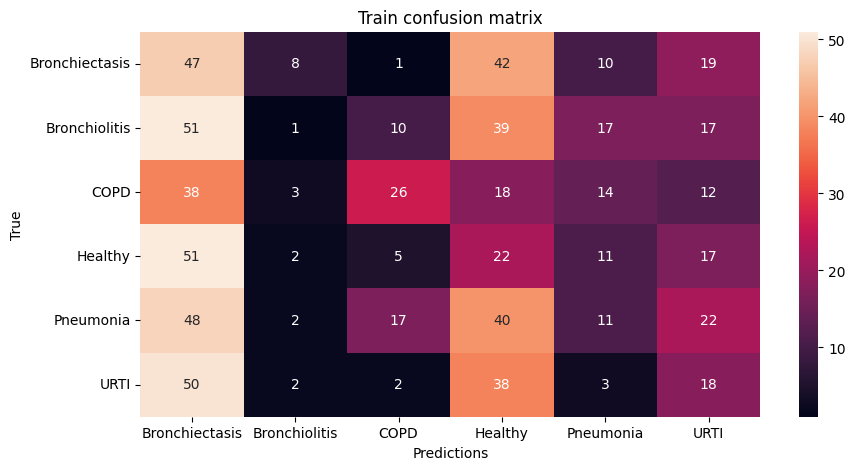

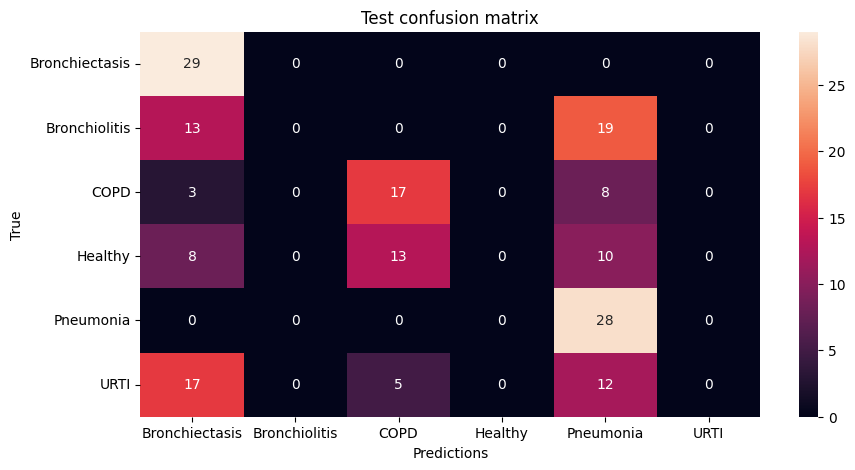


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2:

Train Accuracy: 0.2371376811594203

Train Loss: 1.6948908878409343

Train F1 Score: 0.20488909599573715

Test Accuracy: 0.25473484848484845

Test Loss: 1.6739434599876404

Test F1 Score: 0.18916239713629088




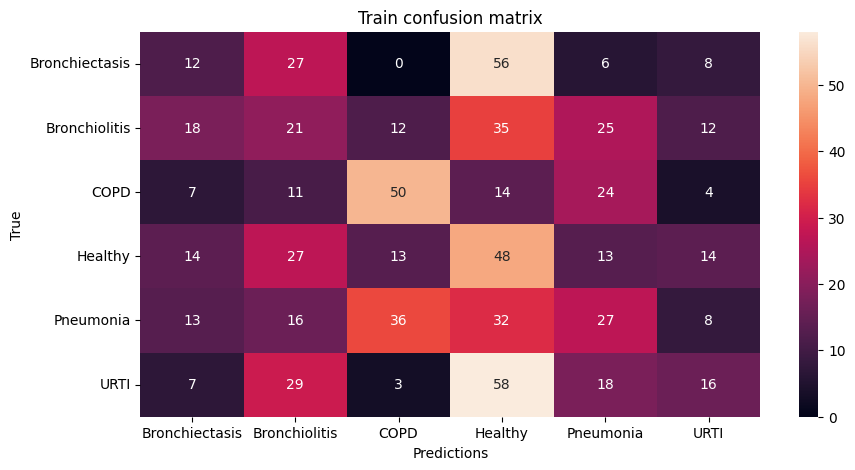

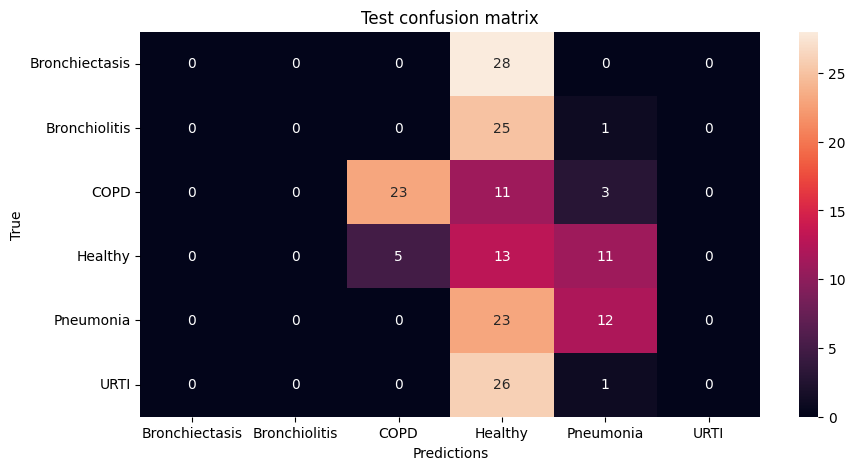


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.28903985507246377

Train Loss: 1.6274006055748982

Train F1 Score: 0.22991355443778244

Test Accuracy: 0.34753787878787873

Test Loss: 1.6187650561332703

Test F1 Score: 0.23358761767546335




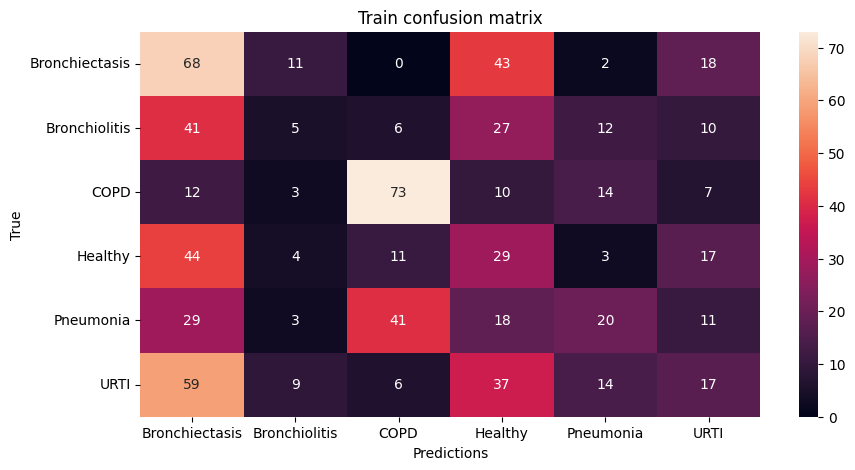

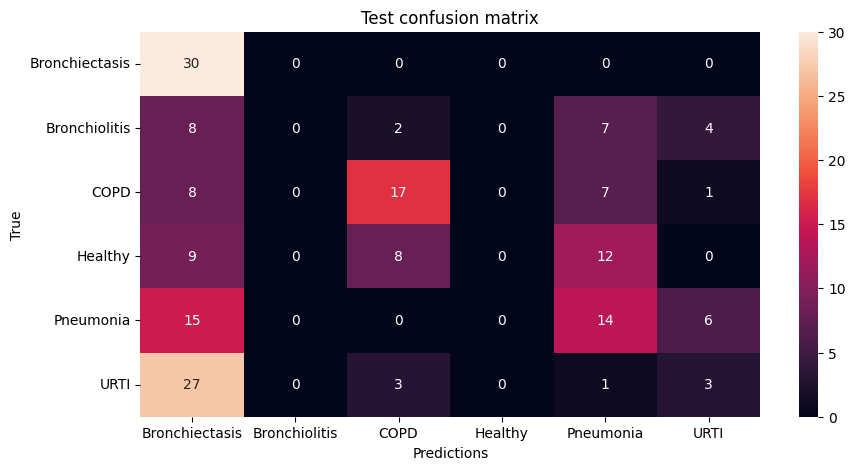


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 4:

Train Accuracy: 0.29719202898550723

Train Loss: 1.6245082305825276

Train F1 Score: 0.21025303135747495

Test Accuracy: 0.3527462121212121

Test Loss: 1.605820616086324

Test F1 Score: 0.2543349688251813




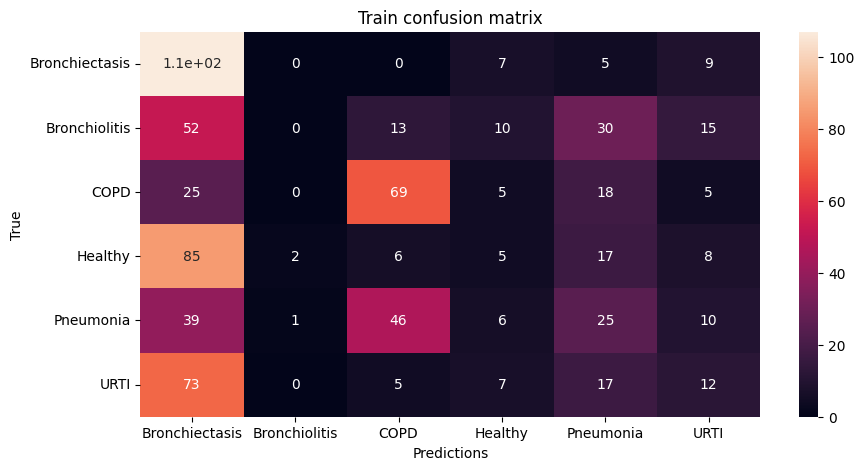

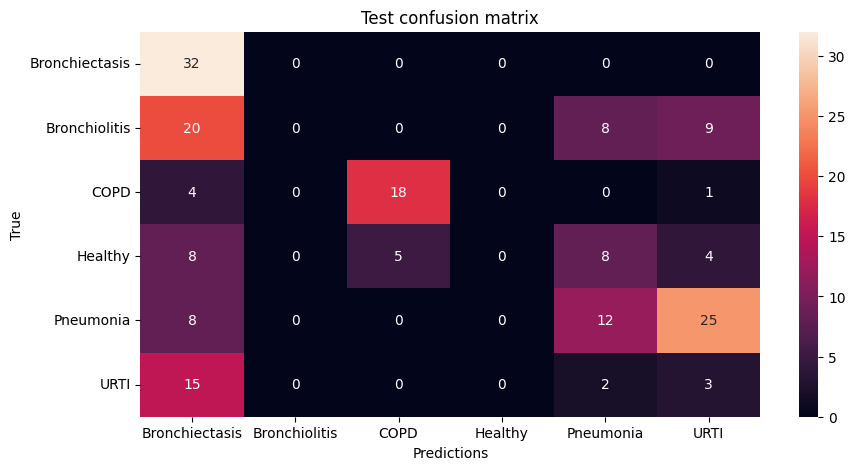


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 0.30126811594202896

Train Loss: 1.6344142893086309

Train F1 Score: 0.2540261052224947

Test Accuracy: 0.3678977272727273

Test Loss: 1.5814923246701558

Test F1 Score: 0.2563649316628774




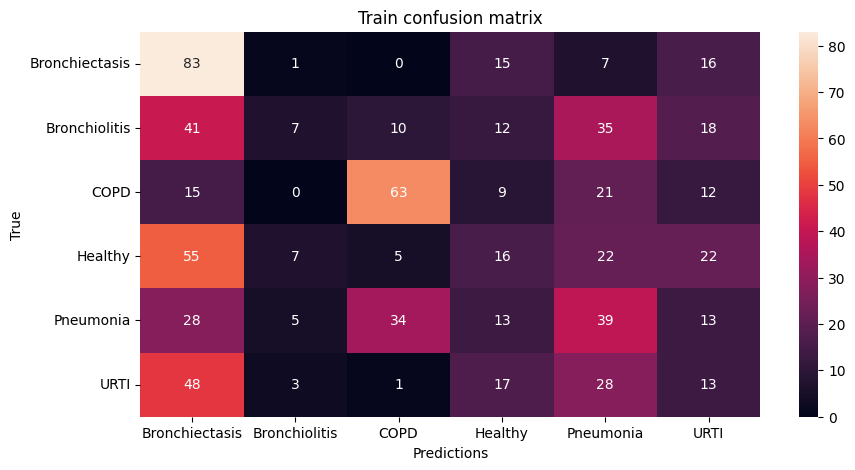

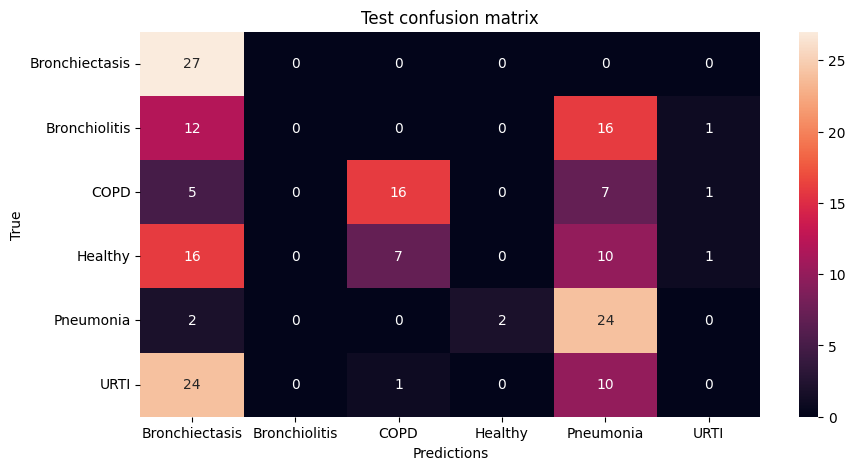


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6:

Train Accuracy: 0.3079710144927536

Train Loss: 1.5763371820035188

Train F1 Score: 0.2690088748931885

Test Accuracy: 0.393939393939394

Test Loss: 1.6062175631523132

Test F1 Score: 0.29657842715581256




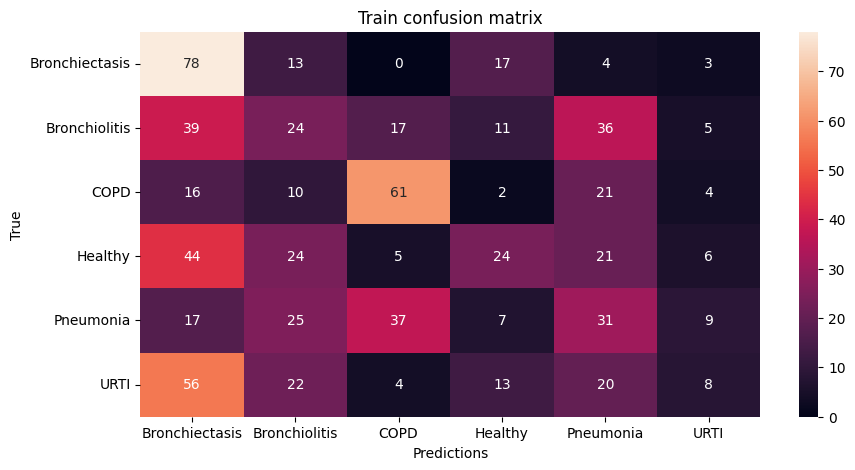

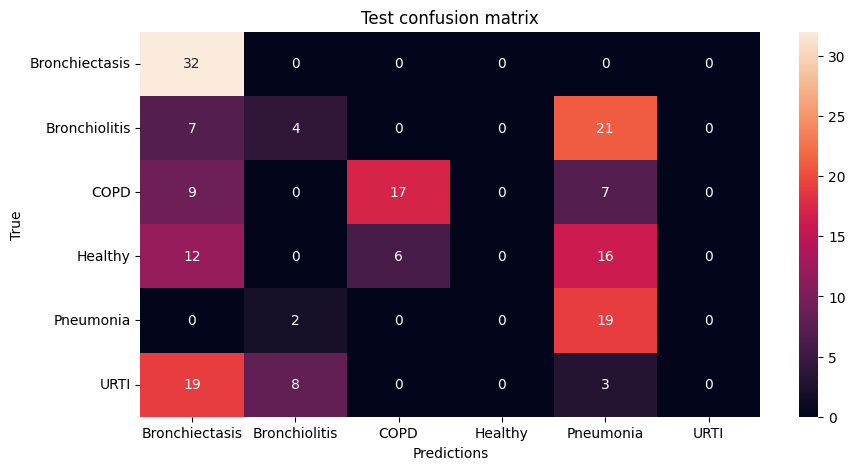


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 7:

Train Accuracy: 0.304981884057971

Train Loss: 1.5945411454076353

Train F1 Score: 0.2651132630265277

Test Accuracy: 0.4275568181818182

Test Loss: 1.5419835845629375

Test F1 Score: 0.33716244002183277




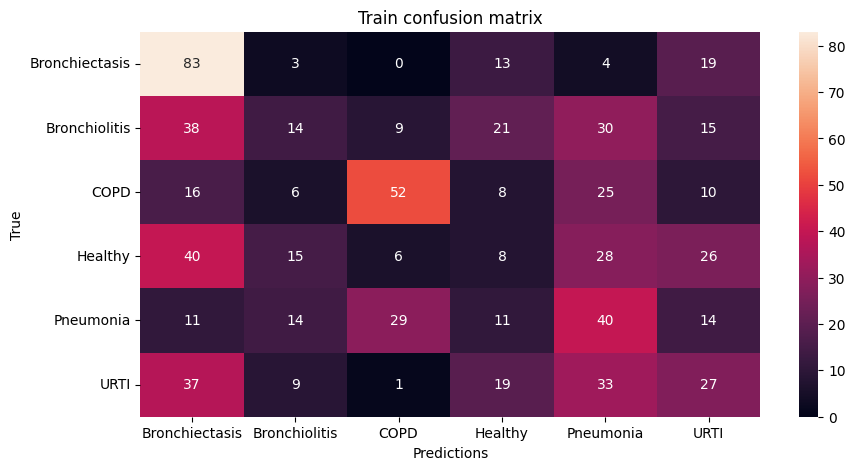

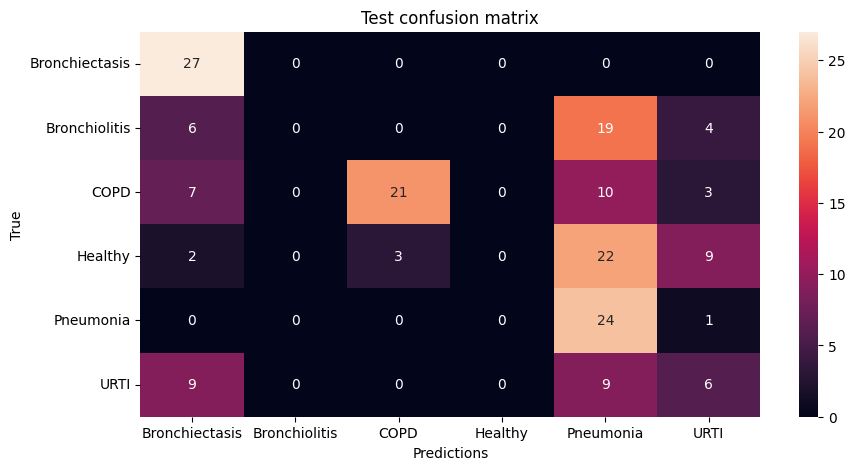


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 8:

Train Accuracy: 0.3214673913043478

Train Loss: 1.58102213818094

Train F1 Score: 0.2822549369024194

Test Accuracy: 0.4616477272727273

Test Loss: 1.4087528983751934

Test F1 Score: 0.37338433663050336




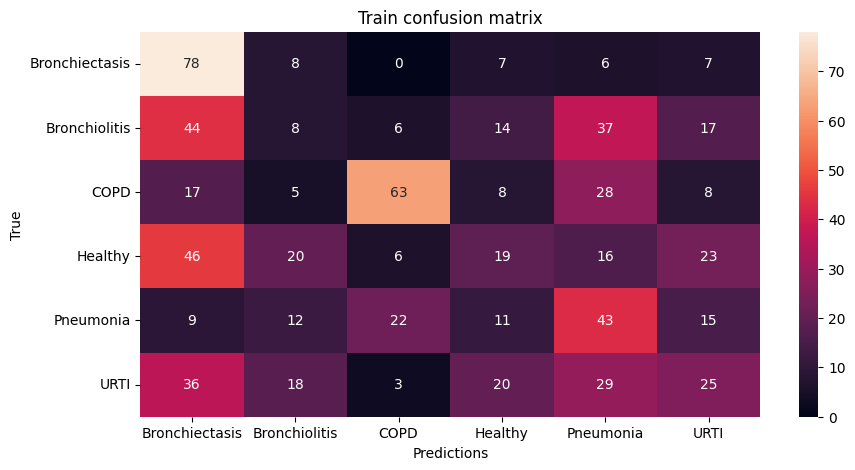

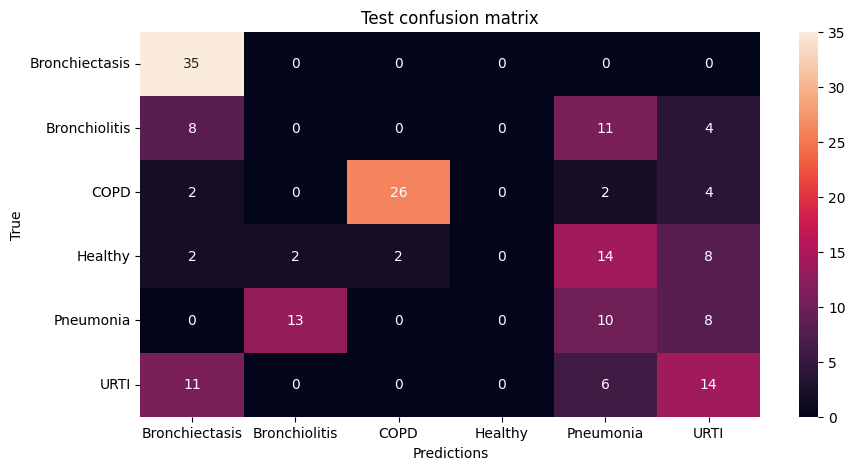


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 9:

Train Accuracy: 0.3561594202898551

Train Loss: 1.5452608129252559

Train F1 Score: 0.3060651181832604

Test Accuracy: 0.5203598484848485

Test Loss: 1.4862876534461975

Test F1 Score: 0.3986211319764455




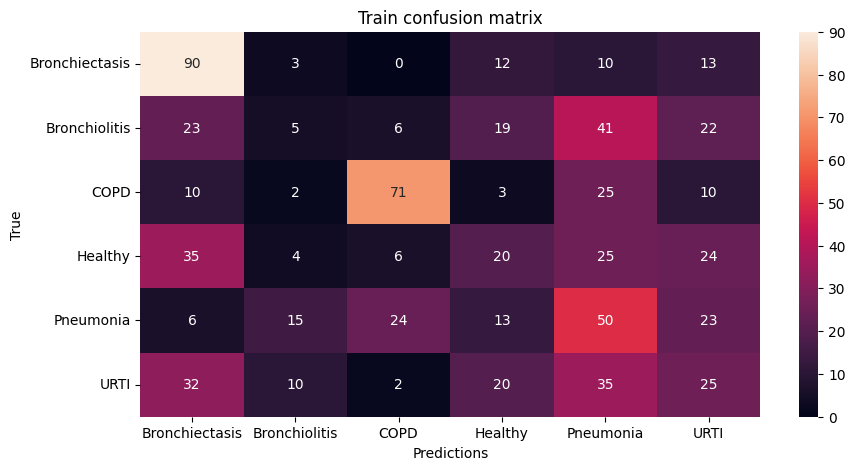

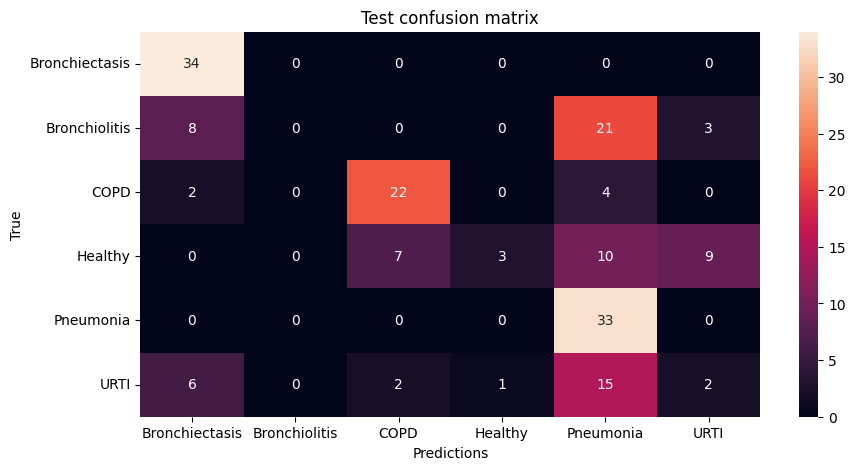


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 10:

Train Accuracy: 0.36068840579710143

Train Loss: 1.5025323111078013

Train F1 Score: 0.2927368108345115

Test Accuracy: 0.45075757575757575

Test Loss: 1.3826385935147603

Test F1 Score: 0.3529509902000427




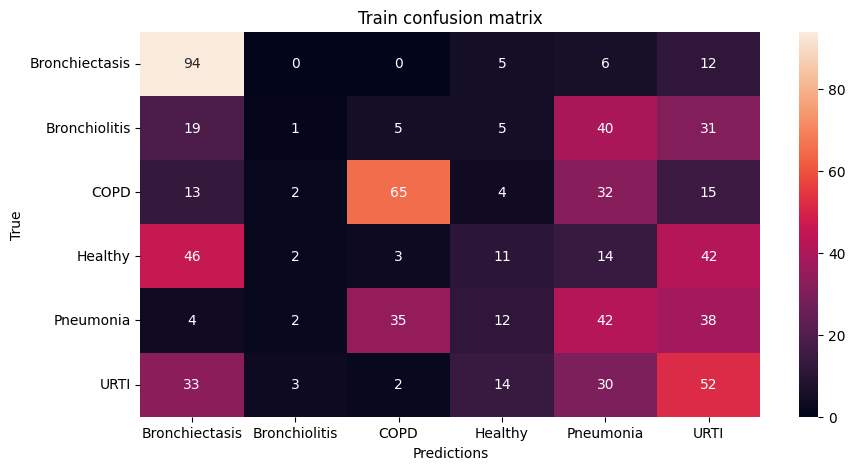

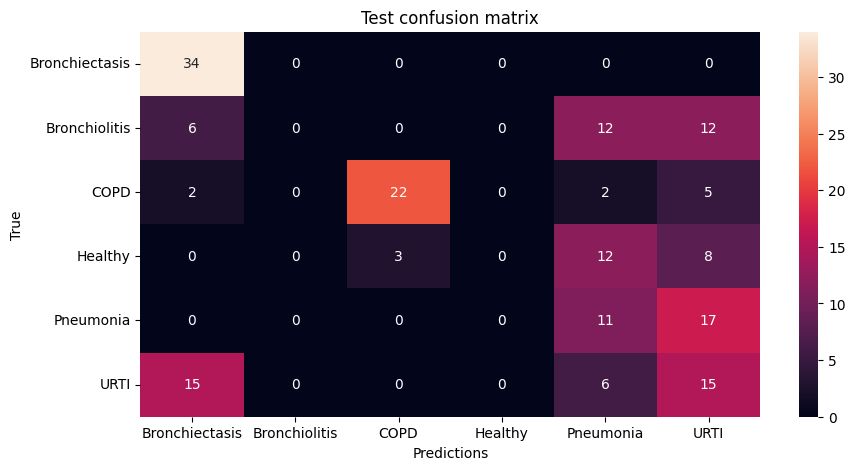


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 11:

Train Accuracy: 0.3594202898550725

Train Loss: 1.5115097709324048

Train F1 Score: 0.3039413658173188

Test Accuracy: 0.4559659090909091

Test Loss: 1.399658977985382

Test F1 Score: 0.3987712214390437




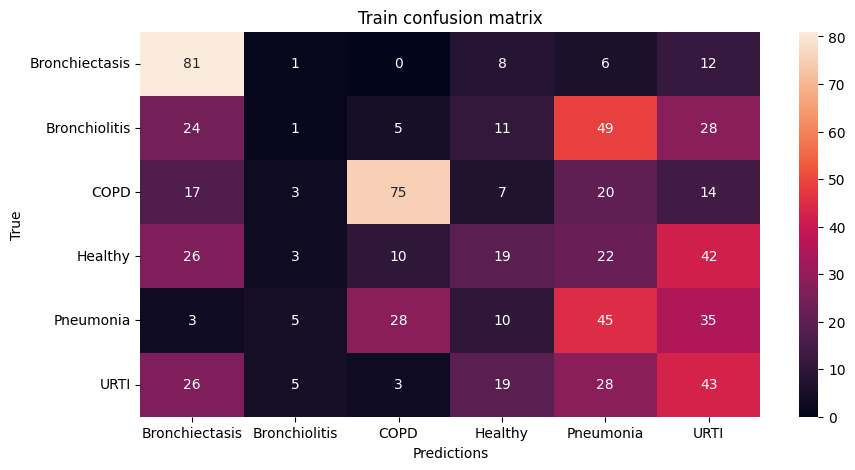

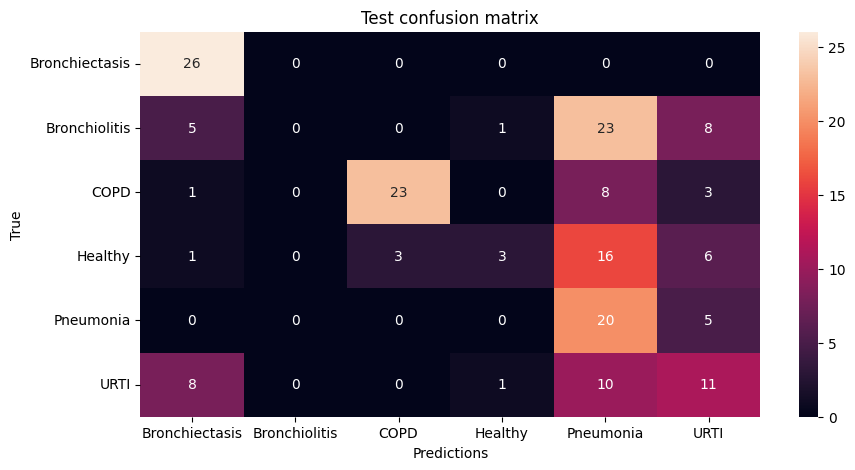


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 12:

Train Accuracy: 0.38831521739130437

Train Loss: 1.475146770477295

Train F1 Score: 0.3440763315428858

Test Accuracy: 0.44412878787878785

Test Loss: 1.4943102598190308

Test F1 Score: 0.3765799055496852




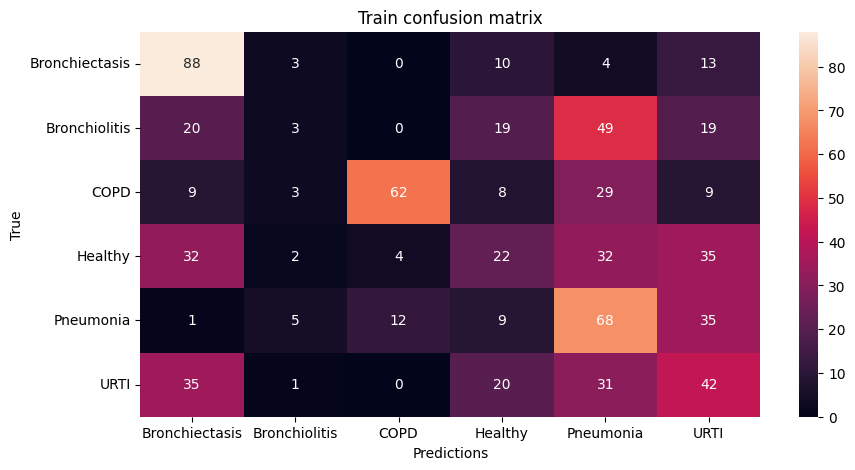

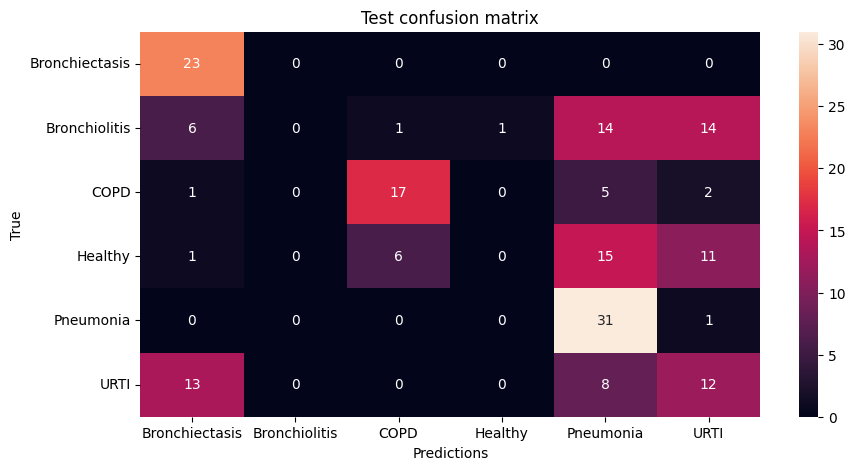


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 13:

Train Accuracy: 0.3913949275362319

Train Loss: 1.4579963684082031

Train F1 Score: 0.33980800535367883

Test Accuracy: 0.5104166666666666

Test Loss: 1.3040749033292134

Test F1 Score: 0.38264258702596027




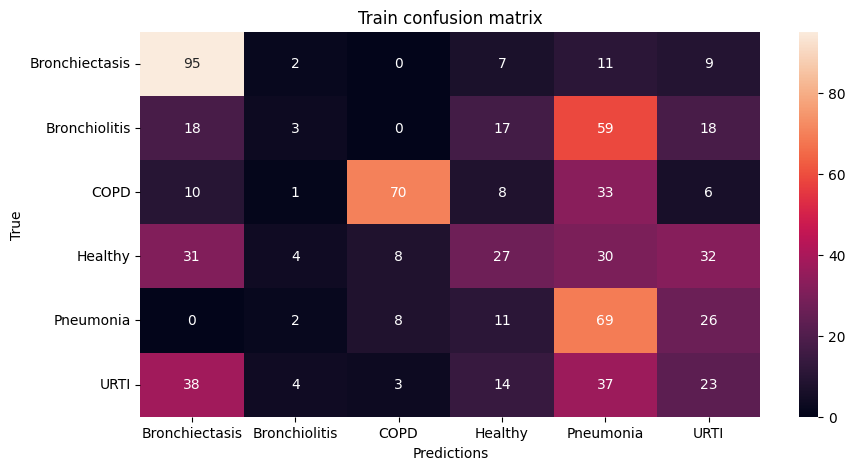

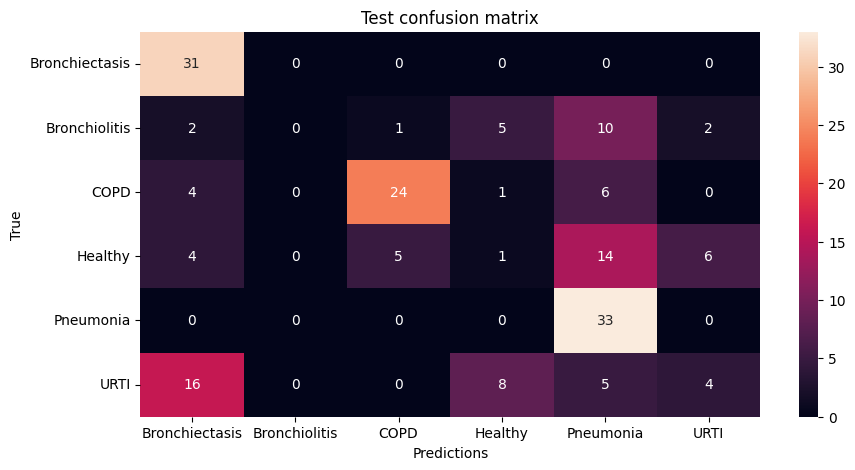


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 14:

Train Accuracy: 0.4156702898550725

Train Loss: 1.3929320521976636

Train F1 Score: 0.3661654565645301

Test Accuracy: 0.5397727272727273

Test Loss: 1.2912057439486186

Test F1 Score: 0.4287317494551341




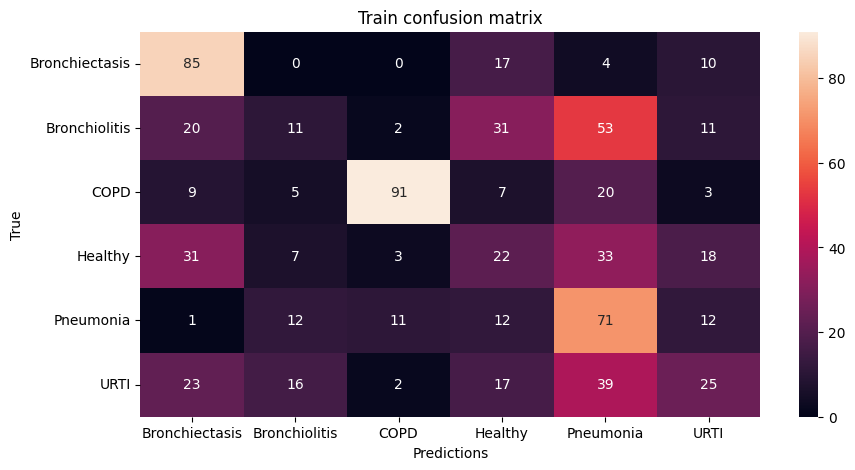

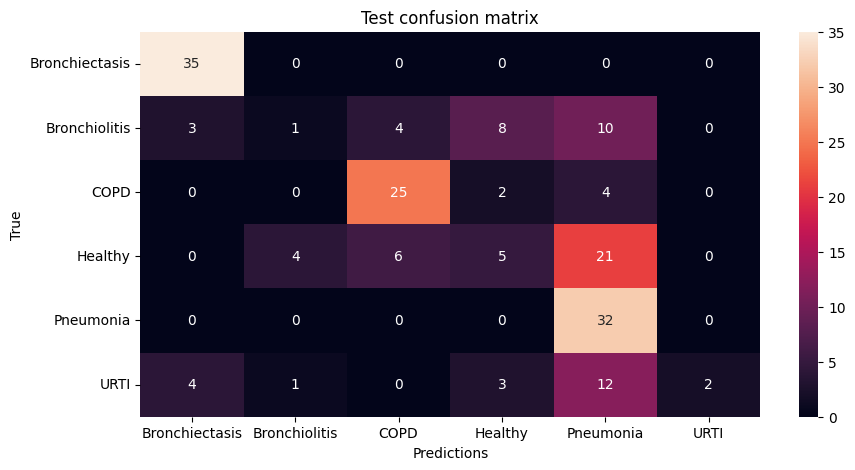


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 15:

Train Accuracy: 0.4330615942028986

Train Loss: 1.3562032554460608

Train F1 Score: 0.37754196058148926

Test Accuracy: 0.3835227272727273

Test Loss: 1.4382208784421284

Test F1 Score: 0.2843976840376854




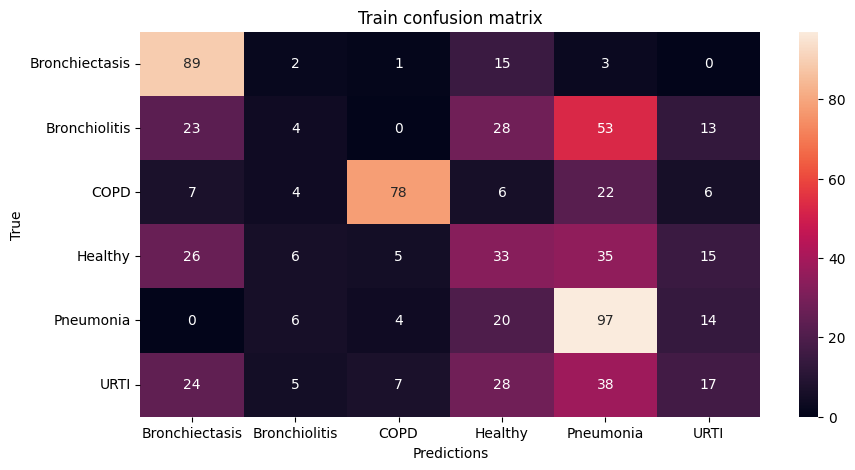

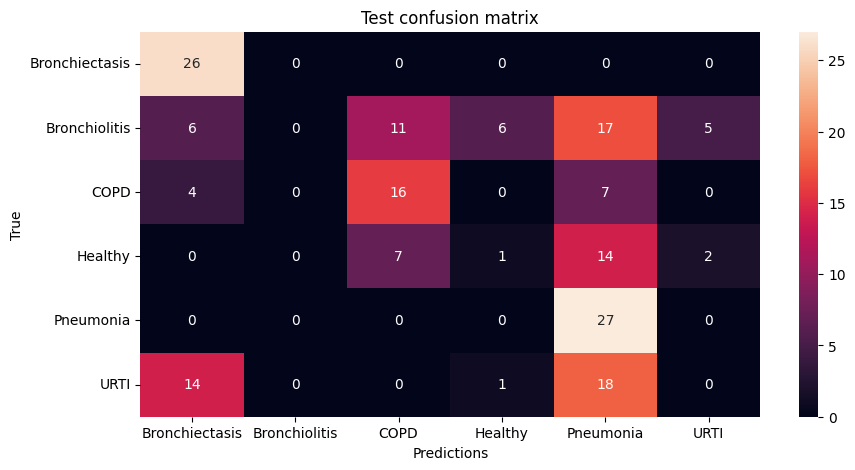


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 16:

Train Accuracy: 0.41548913043478264

Train Loss: 1.3970150740250298

Train F1 Score: 0.36016328568043915

Test Accuracy: 0.5980113636363636

Test Loss: 1.2770592172940571

Test F1 Score: 0.4926825712124507




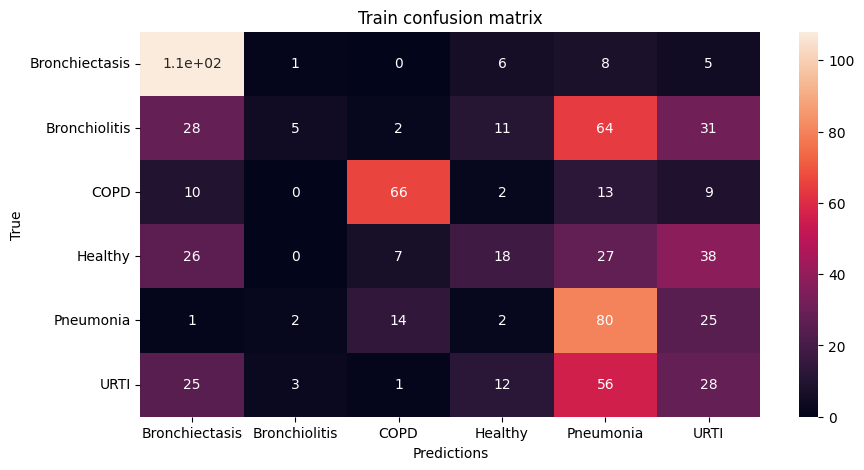

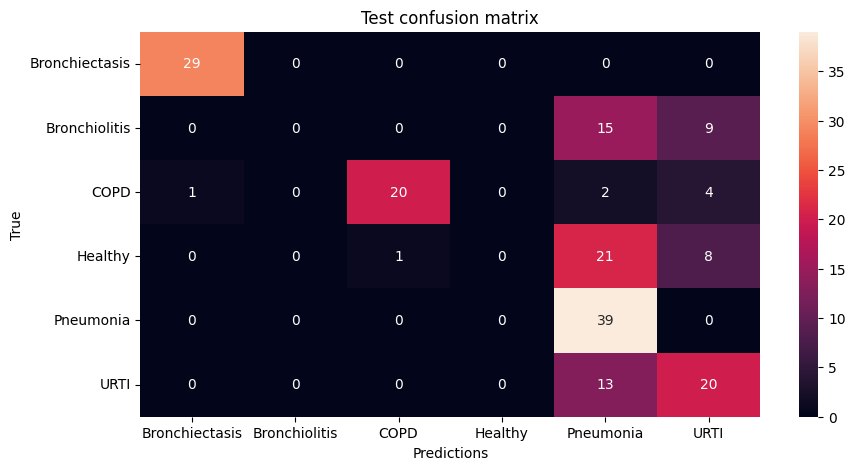


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 17:

Train Accuracy: 0.4332427536231884

Train Loss: 1.376431677652442

Train F1 Score: 0.38273983416349994

Test Accuracy: 0.4630681818181818

Test Loss: 1.257790982723236

Test F1 Score: 0.4113868276278178




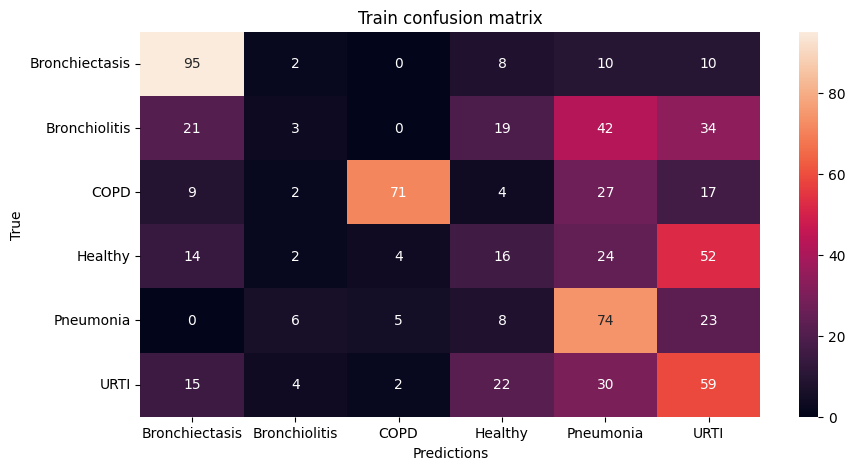

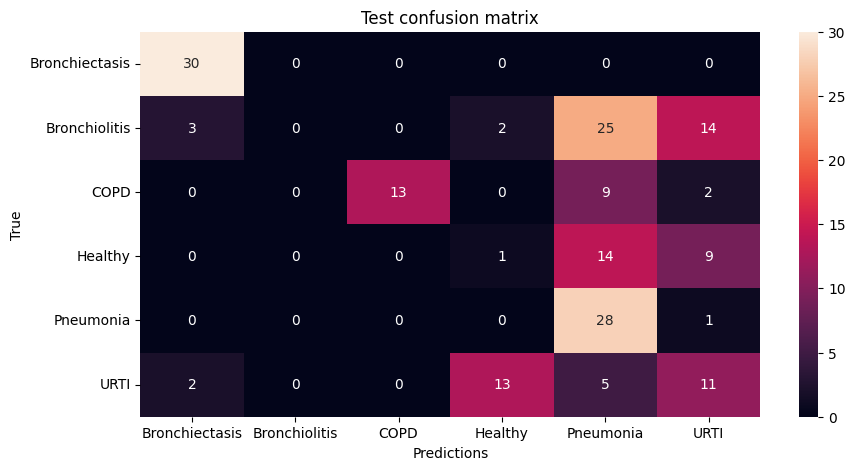


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 18:

Train Accuracy: 0.482518115942029

Train Loss: 1.2711863725081733

Train F1 Score: 0.44963169745776965

Test Accuracy: 0.4786931818181818

Test Loss: 1.1895273526509602

Test F1 Score: 0.4118143568436305




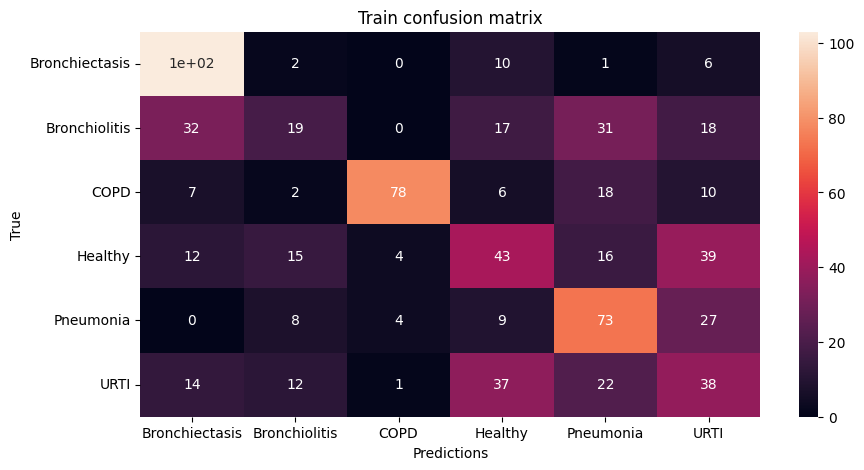

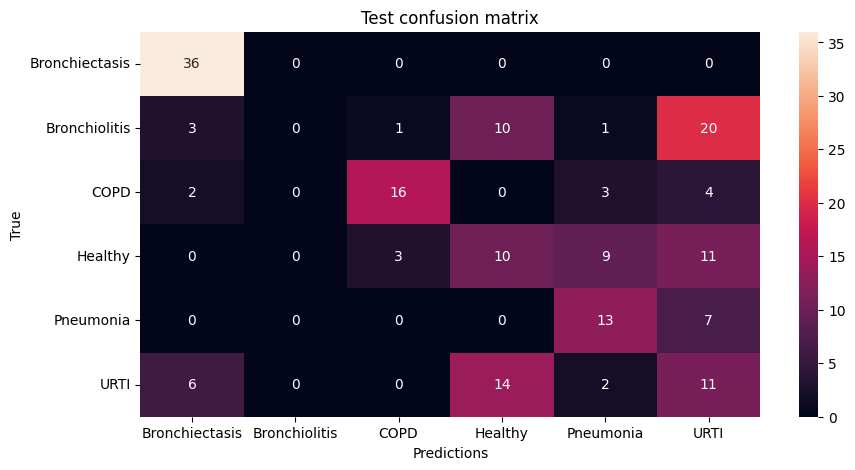


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 19:

Train Accuracy: 0.5123188405797101

Train Loss: 1.2825072926023733

Train F1 Score: 0.47881540396939154

Test Accuracy: 0.5260416666666666

Test Loss: 1.2140267888704936

Test F1 Score: 0.43327878415584564




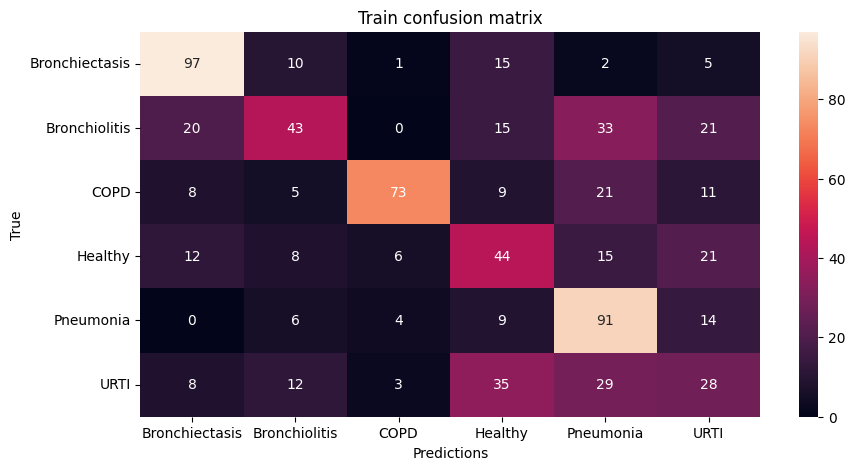

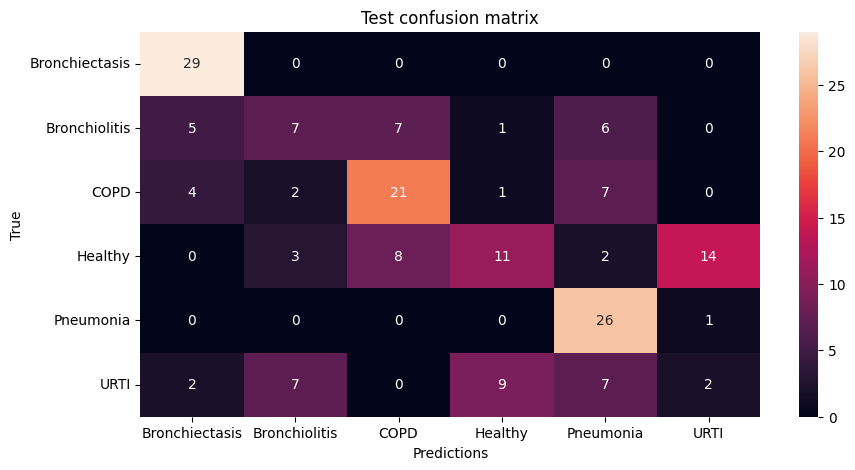


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 20:

Train Accuracy: 0.4890398550724638

Train Loss: 1.2951279438060264

Train F1 Score: 0.44851188815158344

Test Accuracy: 0.46117424242424243

Test Loss: 1.3246240417162578

Test F1 Score: 0.38036225239435834




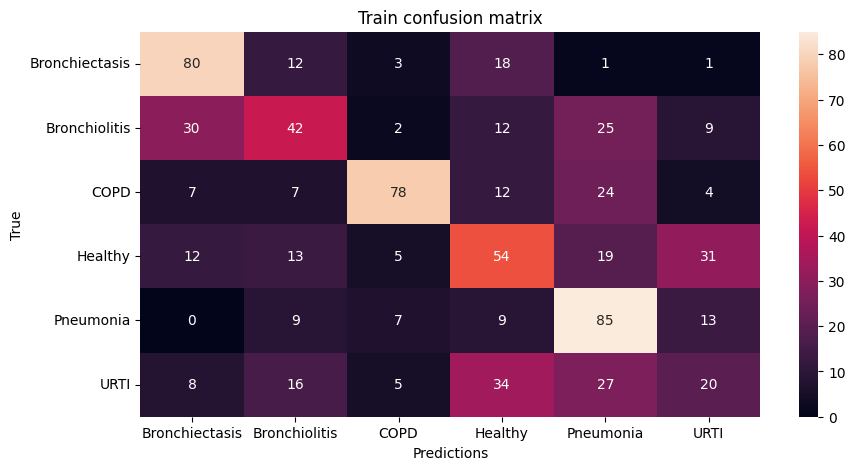

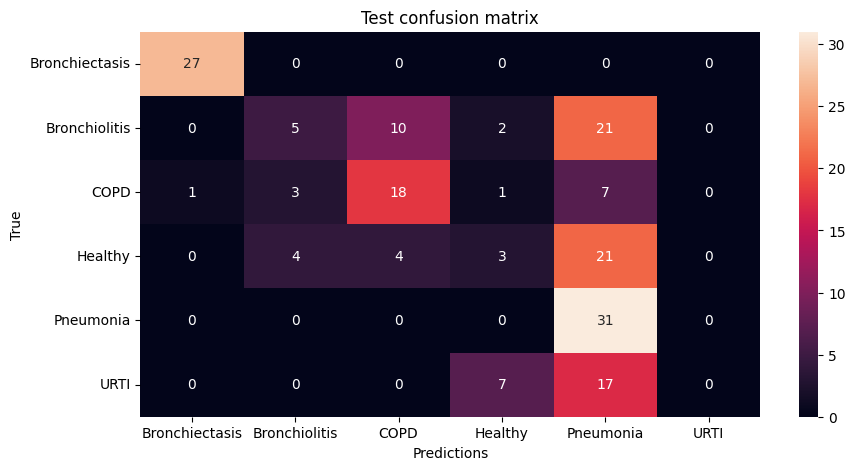


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 21:

Train Accuracy: 0.5241847826086957

Train Loss: 1.23908610706744

Train F1 Score: 0.4762484988440638

Test Accuracy: 0.5951704545454546

Test Loss: 1.2071343262990315

Test F1 Score: 0.5545612176259359




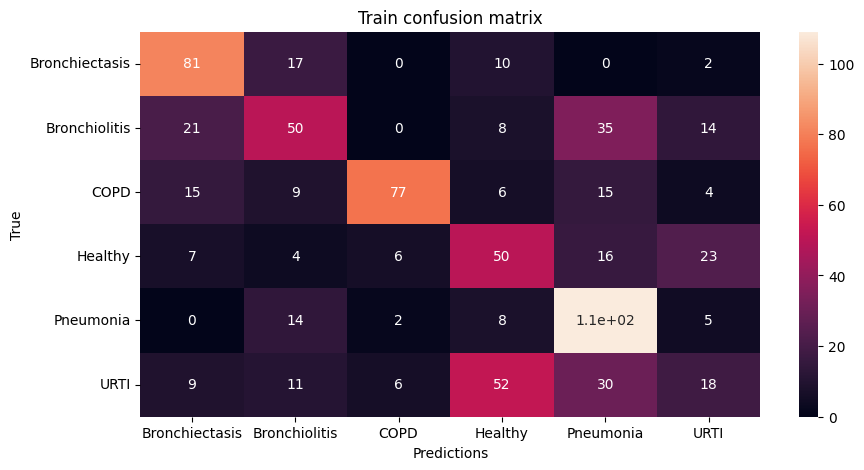

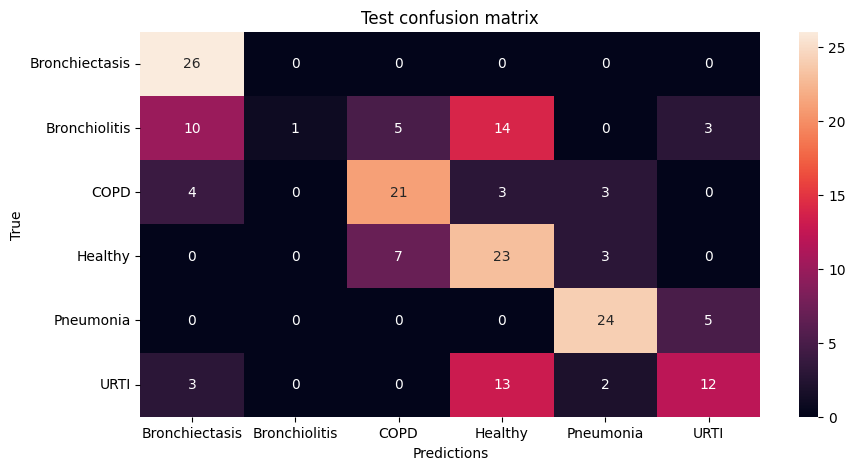


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 22:

Train Accuracy: 0.5871376811594203

Train Loss: 1.1460502899211387

Train F1 Score: 0.538180991359379

Test Accuracy: 0.5875946969696969

Test Loss: 1.0054970781008403

Test F1 Score: 0.5056926061709722




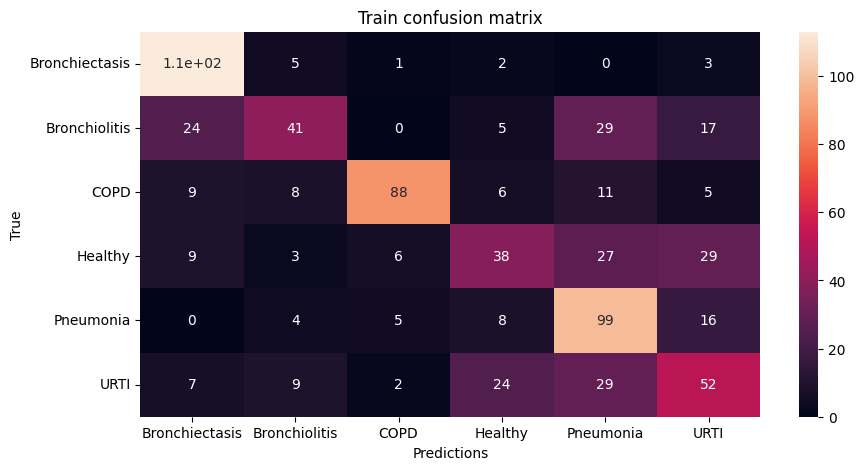

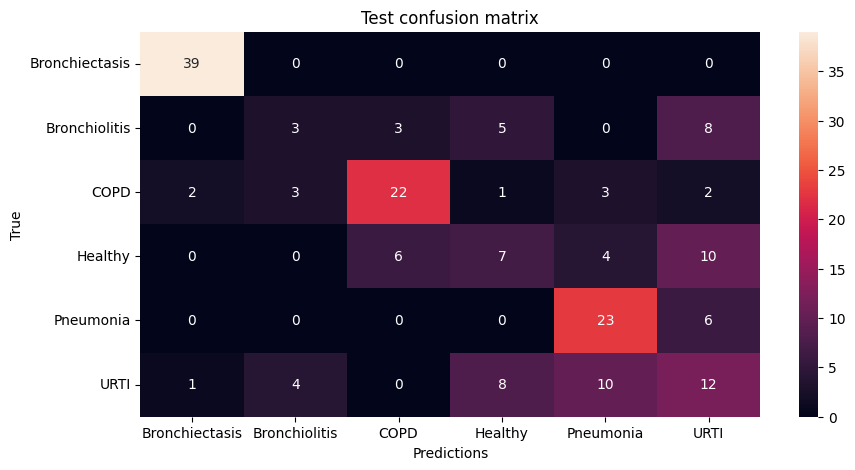


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 23:

Train Accuracy: 0.5634057971014493

Train Loss: 1.0829016592191614

Train F1 Score: 0.5331687123879142

Test Accuracy: 0.6657196969696969

Test Loss: 0.9251645306746165

Test F1 Score: 0.6020004053910574




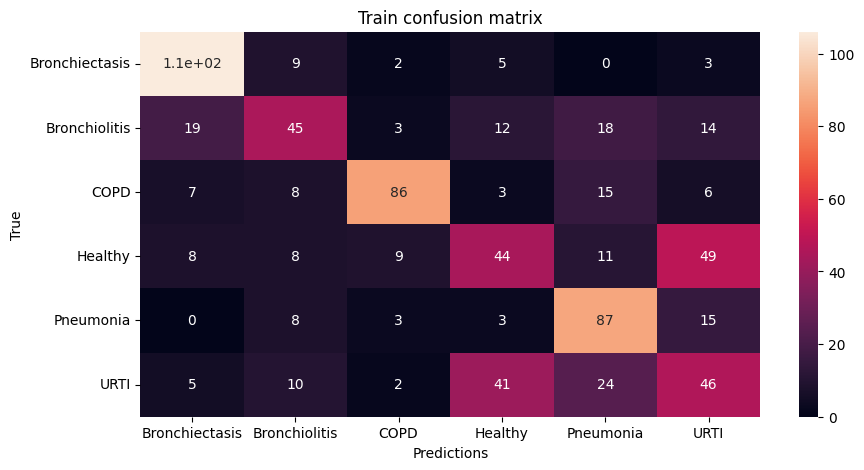

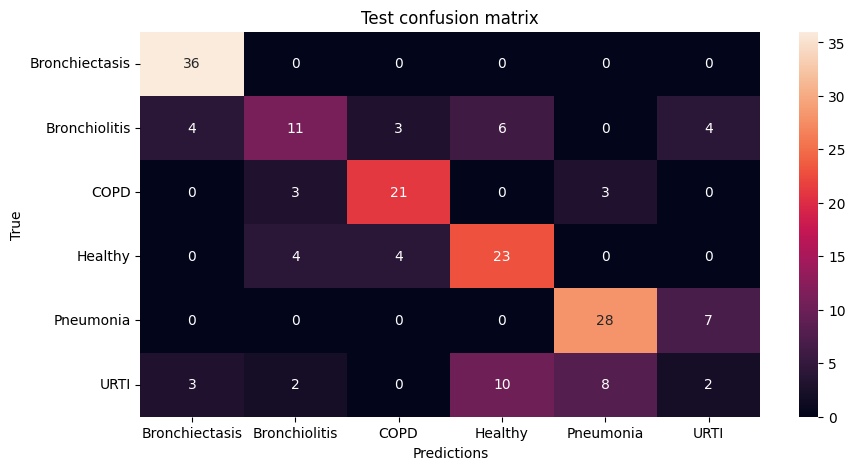


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 24:

Train Accuracy: 0.595018115942029

Train Loss: 1.0504241015600122

Train F1 Score: 0.5557884055635204

Test Accuracy: 0.5421401515151515

Test Loss: 1.1142059365908306

Test F1 Score: 0.4848405917485555




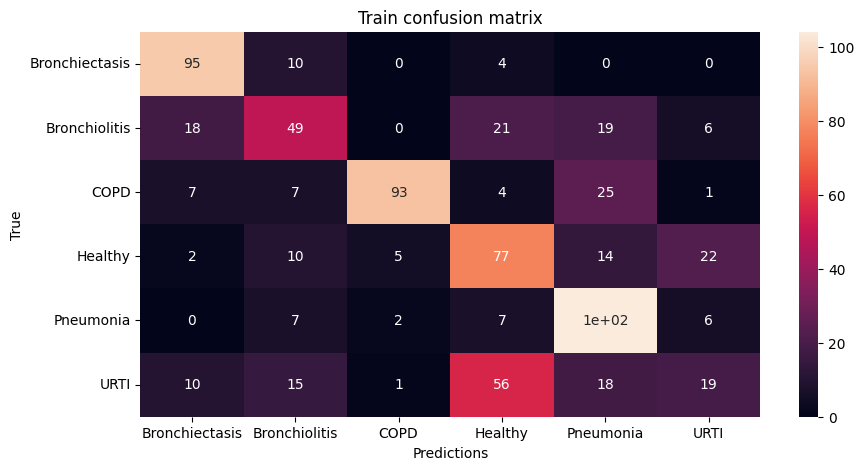

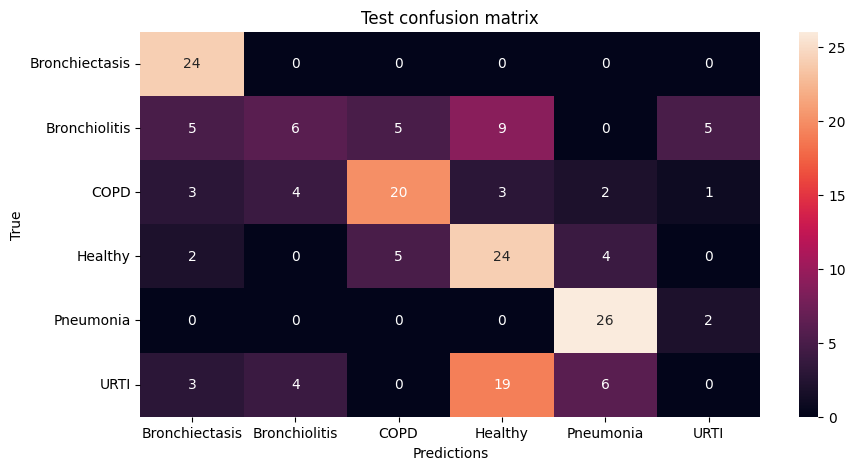


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 25:

Train Accuracy: 0.5792572463768115

Train Loss: 1.0287147345750227

Train F1 Score: 0.5396717631298563

Test Accuracy: 0.5700757575757576

Test Loss: 1.1465285420417786

Test F1 Score: 0.46813344955444336




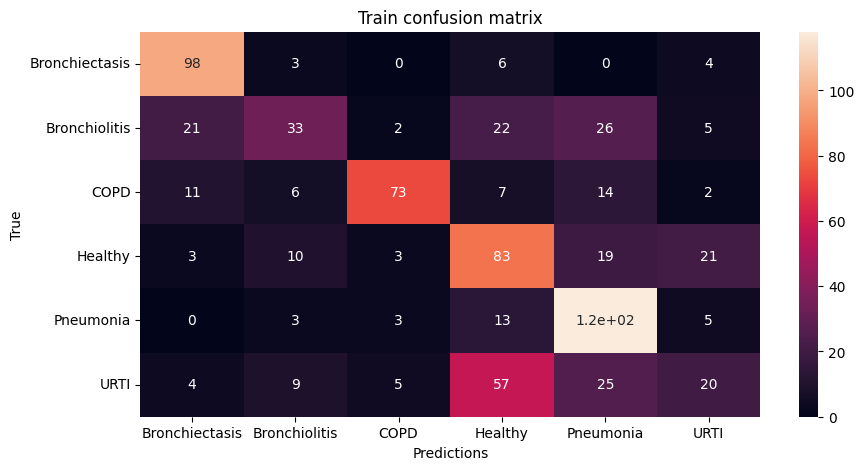

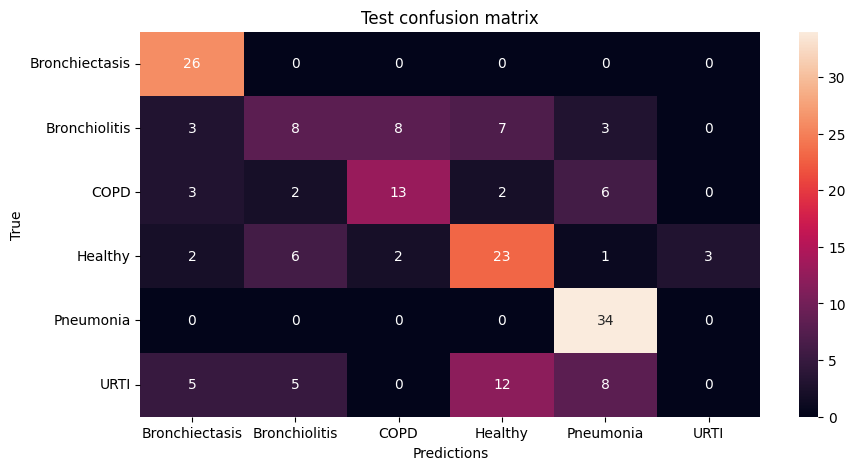


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 26:

Train Accuracy: 0.630072463768116

Train Loss: 0.935313564279805

Train F1 Score: 0.6006835984147113

Test Accuracy: 0.616003787878788

Test Loss: 1.025621771812439

Test F1 Score: 0.5647608985503515




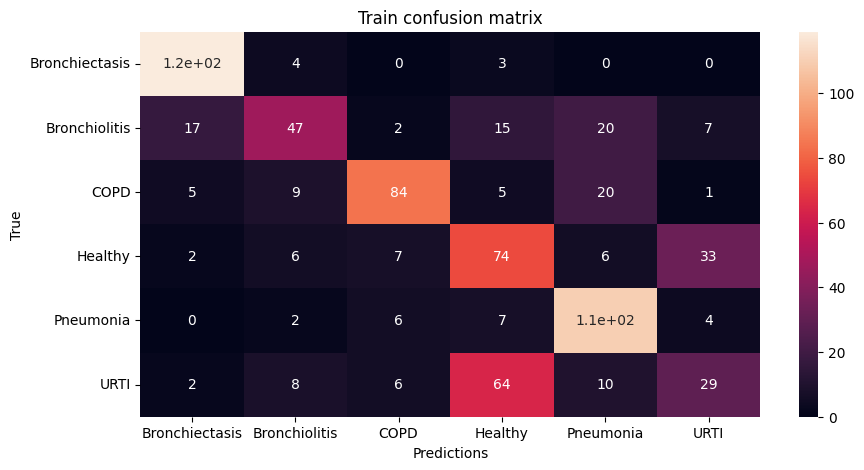

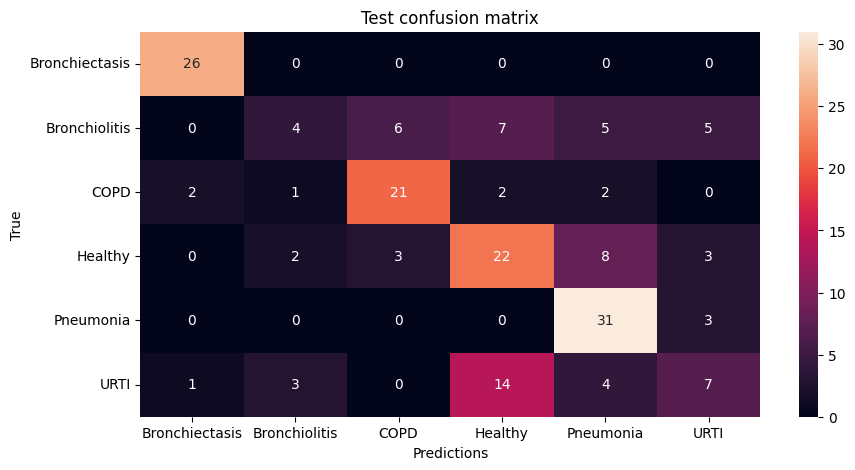


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 27:

Train Accuracy: 0.6215579710144927

Train Loss: 0.950034138949021

Train F1 Score: 0.5663811719935873

Test Accuracy: 0.5643939393939393

Test Loss: 0.9760374029477438

Test F1 Score: 0.5142884999513626




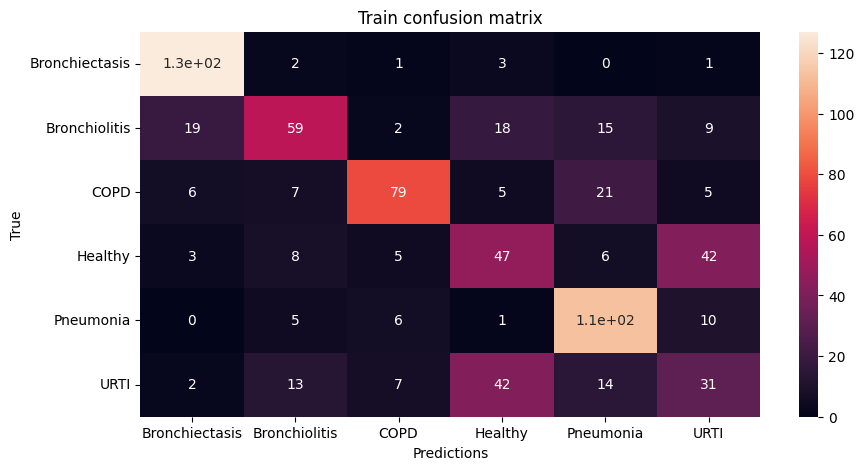

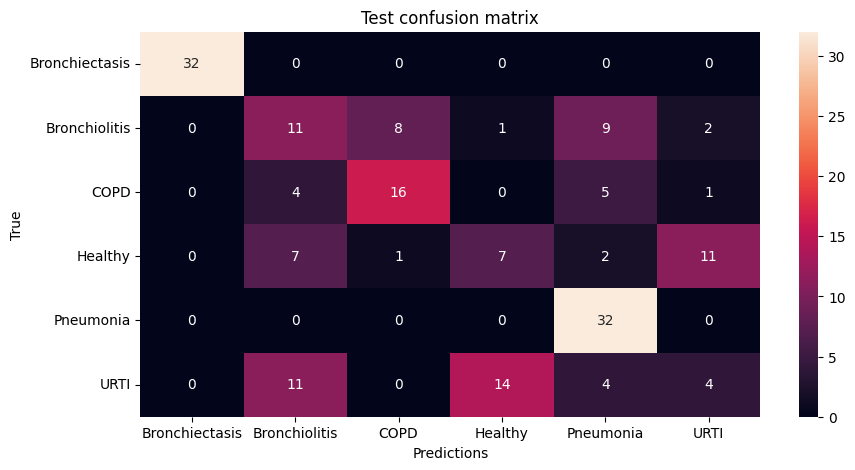


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 28:

Train Accuracy: 0.6529891304347827

Train Loss: 0.9042413156965504

Train F1 Score: 0.611483606307403

Test Accuracy: 0.600378787878788

Test Loss: 1.0925801893075306

Test F1 Score: 0.5515387604633967




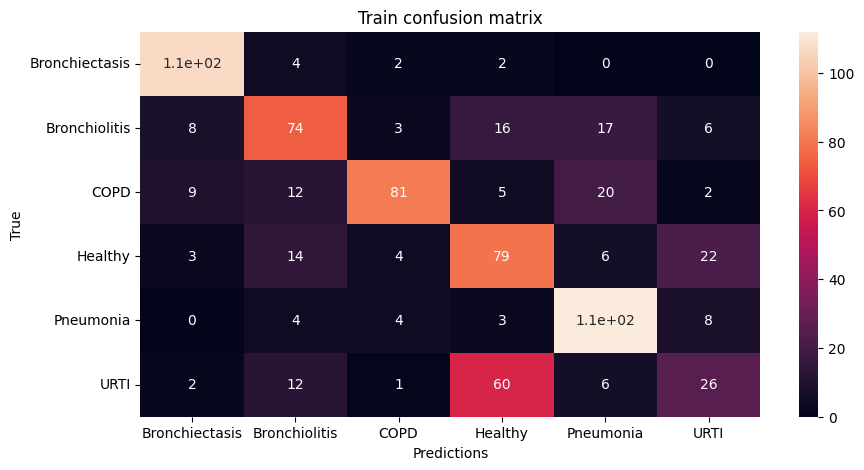

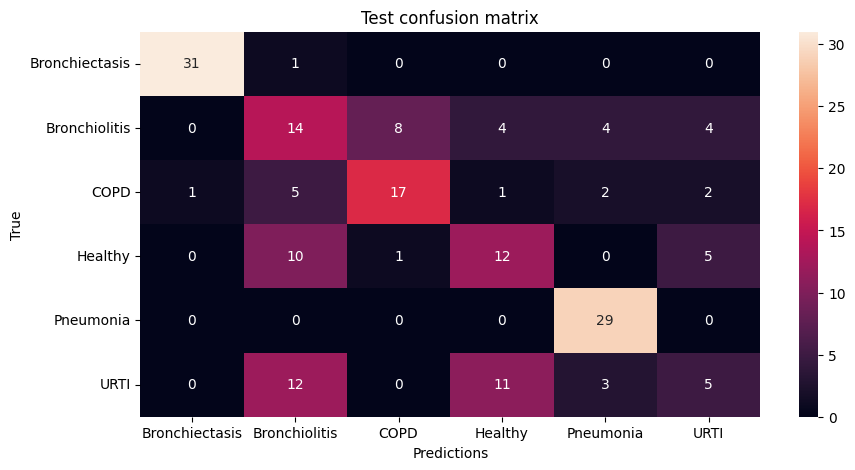


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 29:

Train Accuracy: 0.6512681159420289

Train Loss: 0.8891094508378402

Train F1 Score: 0.6277577695639237

Test Accuracy: 0.6988636363636364

Test Loss: 0.8206435342629751

Test F1 Score: 0.652791827917099




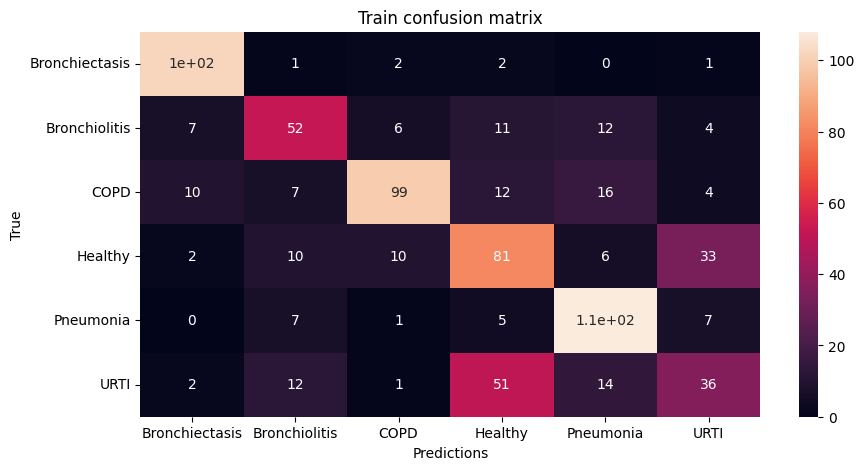

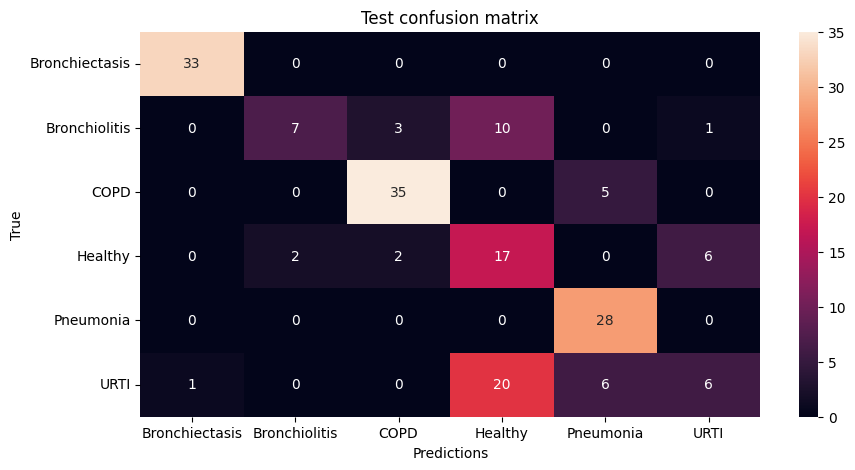


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 30:

Train Accuracy: 0.6510869565217391

Train Loss: 0.8614824932554493

Train F1 Score: 0.6294236066548721

Test Accuracy: 0.6425189393939393

Test Loss: 1.0264524122079213

Test F1 Score: 0.5873652299245199




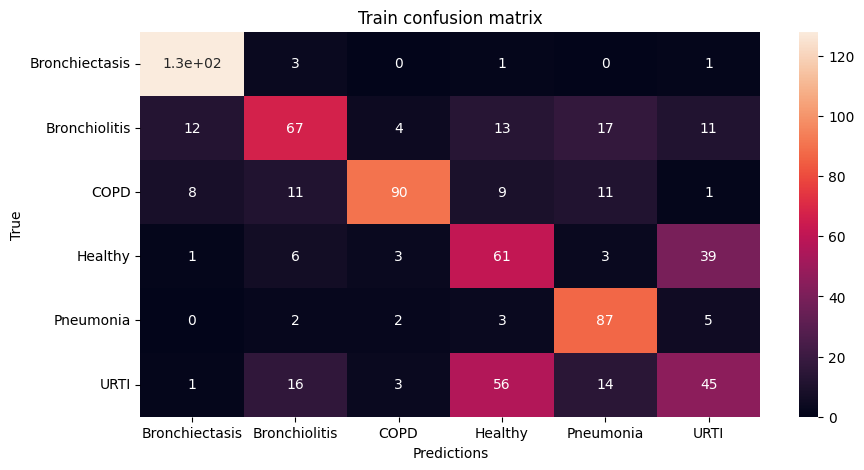

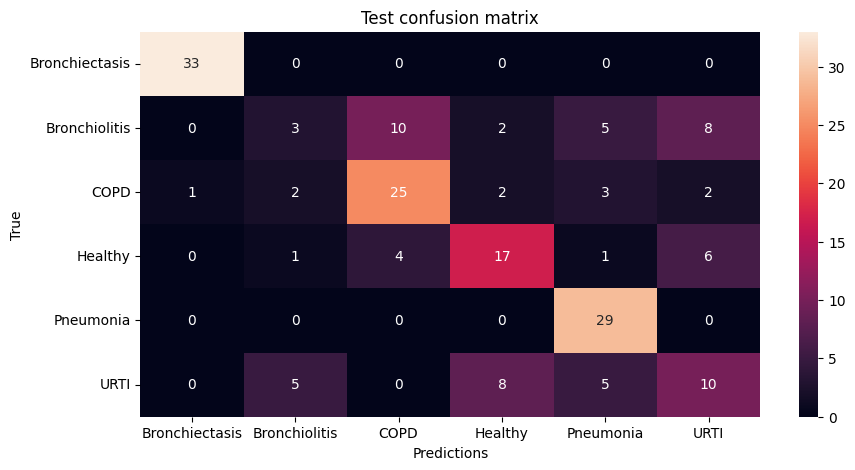


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 31:

Train Accuracy: 0.6401268115942029

Train Loss: 0.9199936908224354

Train F1 Score: 0.6145964692468229

Test Accuracy: 0.5123106060606061

Test Loss: 1.1465237935384114

Test F1 Score: 0.4235896170139313




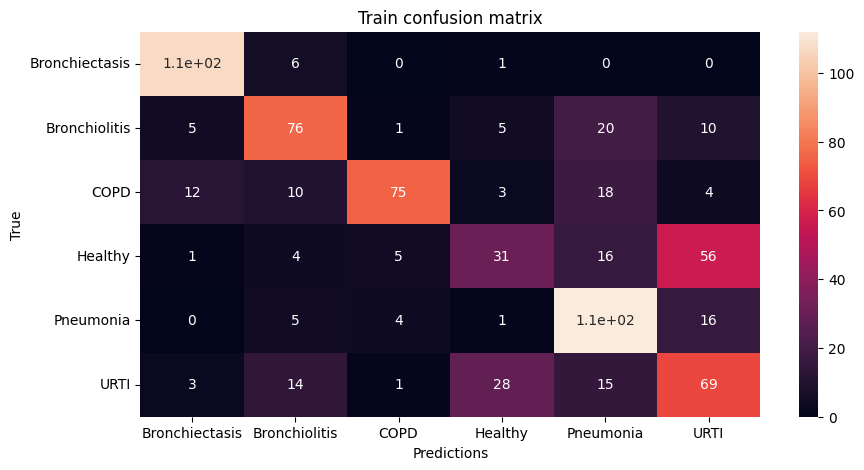

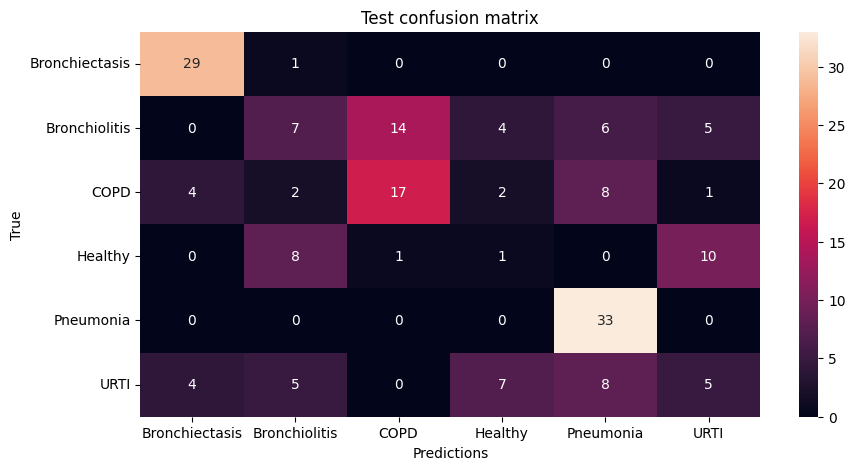


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 32:

Train Accuracy: 0.6867753623188405

Train Loss: 0.821171408114226

Train F1 Score: 0.6742706791214321

Test Accuracy: 0.5857007575757576

Test Loss: 1.0908138851324718

Test F1 Score: 0.525751973191897




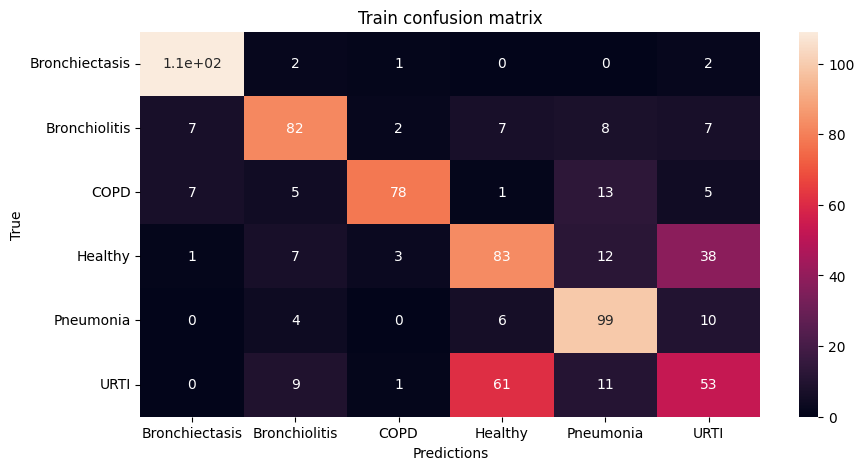

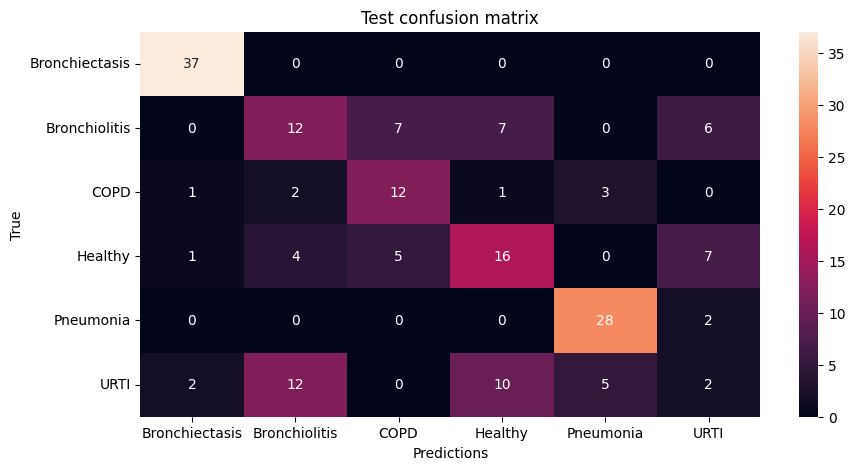


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 33:

Train Accuracy: 0.6552536231884057

Train Loss: 0.7887604703073916

Train F1 Score: 0.6249486026556595

Test Accuracy: 0.5336174242424242

Test Loss: 1.4454606771469116

Test F1 Score: 0.4705885549386342




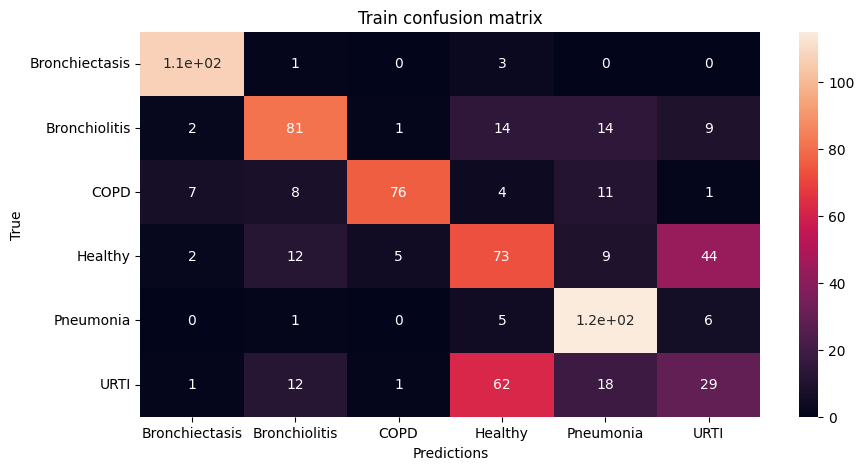

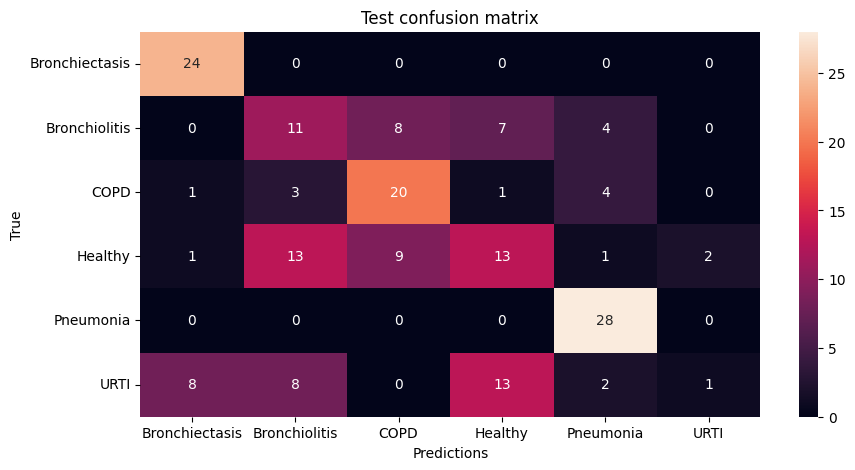


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
epochs=100
train_model(model,epochs)